In [1]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression 
from sklearn.preprocessing import PolynomialFeatures 
url = 'C:/Users/china/Downloads/descarga.csv'

df = pd.read_csv(url)
filtro = df["Manabí"][20:]
filtro

20       2
21       3
22       4
23       5
24       8
25       8
26      14
27      21
28      29
29      46
30      72
31      97
32     109
33     129
34     157
35     181
36     207
37     231
38     255
39     285
40     302
41     332
42     365
43     384
44     407
45     424
46     458
47     490
48     517
49     544
50     552
51     578
52     607
53     627
54     655
55     697
56     726
57     741
58     760
59     790
60     810
61     826
62     839
63     866
64     897
65     949
66     970
67     987
68    1011
69    1025
70    1036
71    1044
72    1044
73    1045
74    1046
Name: Manabí, dtype: int64

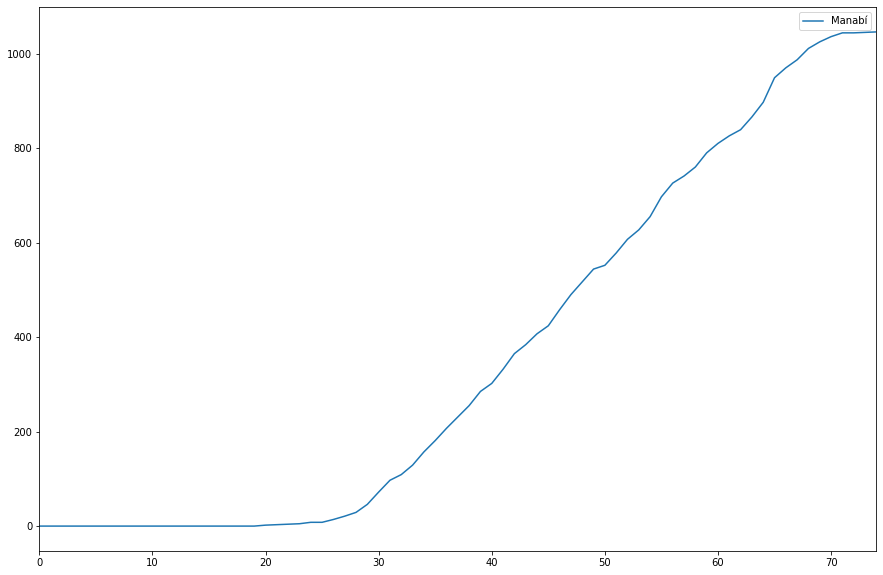

In [2]:
fig, ax = plt.subplots(figsize=(15, 10))
df.plot(ax=ax)

In [3]:
##TASA DE CRECIMIENTO POBLACIONAL= 
## EN BASE A LOS DATOS DE NUMERO DE INFECTADOS EN LA PROVINCIA DE MANABÍ DETERMINAREMOS LA TASA DE INCREMENTO EPIDEMIOLOGICO
## PARA ELLO USAREMOS EL MODELO SIR PARA DETERMINAR BETA Y GAMMA PARA POSTERIORMENTE SACAR R0 QUE LLEGARIA A SER NUESTRA 
## TASA DE INCREMENTO
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from scipy.integrate import odeint

def loss(point, data, s0, i0, r0):
    size = len(data)
    beta, gamma = point
    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
    solution = solve_ivp(SIR, [0, size], [s0,i0,r0], t_eval=np.arange(0, size, 1), vectorized=True)
    return np.sqrt(np.mean((solution.y[1] - data)**2))
i0=2
r0=10
s0=1788
x=np.array(range(0,55))
filtro = df["Manabí"][20:]
data= filtro
optimal = minimize(loss, [0.001, 0.001], args=(data,s0,i0, r0), method='L-BFGS-B', bounds=[(0.00001,0.4), (0.00001, 0.4)])   
beta, gamma = optimal.x
R0= (beta/gamma)*1500
print("Tasa de crecimiento epidemiologico en manabí")
print(R0)

Tasa de crecimiento epidemiologico en manabí
5.550636786105792


In [28]:
import simpy
import random
import matplotlib.pyplot as pp


#Numero de camas en Manabí
NUM_CAMAS=2000
#Tiempo de consulta = 17min
TIEMPO_CONSULTA=17
#Dias de simulacion = 30
DIAS_SIMULACION=100
#intervalo de llegada de los pacientes 10
INTERVALO_LLEGADA=4
#Cantidad de medicos=93
CANTIDAD_MEDICOS=12000

#COSTO POR PACIENTE= 300$ PRUEBAS ASIGNADAS POR EL MINISTERIO 80$ PRUEBAS A PERSONAS PARTICULARES 180$
COSTO_PACIENTE=80
#RECURSOS/INSUMOS POR DIA PARA UN PACIENTE:
#BATAS=25 unidades
#MASCARILLAS= 25 unididades
#EPP= 1 unidad
#GUANTES= 50 unidades
#PROTECCION OCULAR=1 unidad
#TOTAL DE RECURSOS POR HOSPITAL
TOTAL_RECURSOS=102
TOTAL=1224000
#ROJO= Signos y sintomas graves 50
#AMARILLO = Presencia de sintomas30
#VERDE= Sin factor de riesgo 20

####################### PIRAMIDE DE POBLACION EN MANABÍ #########################################################

#POBLACION DE MANABI
#NIÑOS=490451
#ADOLESCENTES=129727
#ADULTOS Y ADULTOS MAYORES=750265
#TOTAL=1370443
#INFECTADOS=1046
#POBLACION CON RIESGO DE INFECCION=1369397
MAX_PERSONAS=1369397
#PORCENTAJES EN FASCICULO DE POBLACION


#NIÑOS=35%-->479288
#ADOLESCENTES=11%-->150634
#ADULTOS Y ADULTOS MAYORES=54%-->739475
#ADULTOS=20%-->273880
#ADULTOS MAYORES= 34%-->465595
#55% SON HOMBRES Y EL 45 SON MUJERES

#NIÑOS-->0-14   0-7
    #MUJERES=16%-->219103
    #HOMBRES=19%-->260185
    
#ADOLESCENTES-->15-19 0-7
    #MUJERES=5%-->68470
    #HOMBRES=6%-->82164

#ADULTOS-->20-50 2-14
    #MUJERES=9%-->123246
    #HOMBRES=11%-->150634
    
#ADULTOS MAYORES-->  >51 7-21
    #MUJERES=16%-->219104
    #HOMBRES=18%-->246491

#################################################################################################################

tiempo={}
tiempo_atencion={}
adultoMs_fallecidos={}
adultos_fallecidos={}
ninios_fallecidos={}
mujeres_fallecidas={}
hombres_fallecidos={}
cuidados_intensivos={}
mujeres_intensivos={}
hombres_intensivos={}


class AtencionPacientes(object):
    def __init__(self, env, num_cama):
        self.env = env
        self.num_cama = num_cama
        self.camas = simpy.Resource(env, num_cama)
        
    def atender_paciente(self, paciente):
        yield self.env.timeout(random.randint(TIEMPO_CONSULTA-2, TIEMPO_CONSULTA+2))
        print("El paciente se termino de atender: ", paciente, " tiempo de salida: ", self.env.now)
        tiempo_atencion[paciente]=env.now
       
            
def Ingreso_Paciente(env, paciente, consulta):
    llegada= env.now
    print('Ingreso del paciente con Covid-19 %s a la hora %.2f.' % (paciente, env.now))
    #Si el valor randomico es 1 hace referencia a la poblacion masculina mas en el case de ser 2 a la ploblacion femenina
    genero_paciente= random.randint(1,2)
    if(genero_paciente== 1):
        genero="Mujer"
    else:
        genero="Hombre"
    poblacion= random.randint(0,100)
    global tipo
    if(poblacion>55):
        tipo= "adultos mayores"
    elif(poblacion<55 and poblacion>20):
        tipo= "adultos"
    elif(poblacion<20 and poblacion>15):
        tipo= "adolescente"
    elif(poblacion<15 and poblacion>1):
        tipo= "ninio"
    tipo_poblacion=tipo
    with consulta.camas.request() as cama:
            yield env.process(consulta.atender_paciente(paciente))
            print('Paciente [%s] a finalizado la consulta a las %.2f.' % (paciente, env.now))
            tiempo[paciente]=env.now
            dias_esperando = random.randint(1,2) #Numero de dias maximo que puede esperar sin ser asignado a una cama dentro del hospital
            requerimiento = yield cama | env.timeout(dias_esperando) #Asignar un tiempo de espera
            wait = env.now - llegada
            if cama in requerimiento:
                if(tipo_poblacion == "adultos"):
                    print("Es asintomatico")
                    print("El paciente: ", paciente, genero,"perteneciente a el grupo de ",tipo_poblacion," en estado AMARILLO se le asigna una CAMA ")
                    estado= random.randint(0,100)
                    if(estado>25):
                        print("El paciente: ", paciente, genero,"perteneciente a el grupo de ",tipo_poblacion," pasa a un estado ROJO con neumonia ")
                        estado= random.randint(0,100)
                        if(estado>25):
                            print("El paciente: ", paciente, genero,"perteneciente a el grupo de ",tipo_poblacion," pasa a cuidados intensivos ")
                            cuidados_intensivos[env.now]=cuidados_intensivos[env.now]+ 1 if env.now in cuidados_intensivos else  1
                            if(genero=="Mujer"):
                                mujeres_intensivos[env.now]=mujeres_intensivos[env.now]+ 1 if env.now in mujeres_intensivos else  1
                            else:
                                hombres_intensivos[env.now]=hombres_intensivos[env.now]+ 1 if env.now in hombres_intensivos else  1
                            estado= random.randint(0,100)
                            
                            if(estado>50):
                                print("El paciente: ", paciente, genero,"perteneciente a el grupo de ",tipo_poblacion," fallece ")
                                adultos_fallecidos[env.now]=adultos_fallecidos[env.now]+ 1 if env.now in adultos_fallecidos else  1
                                if(genero=="Mujer"):
                                    mujeres_fallecidas[env.now]=mujeres_fallecidas[env.now]+ 1 if env.now in mujeres_fallecidas else  1
                                else:
                                    hombres_fallecidos[env.now]=hombres_fallecidos[env.now]+ 1 if env.now in hombres_fallecidos else  1
                            else:
                                print("El paciente: ", paciente, genero,"perteneciente a el grupo de ",tipo_poblacion," se recupera de COVID-19 ")
                        else:
                            print("El paciente: ", paciente, genero,"perteneciente a el grupo de ",tipo_poblacion," se recupera de COVID-19 ")
                    else:
                            print("El paciente: ", paciente, genero,"perteneciente a el grupo de ",tipo_poblacion," se recupera de COVID-19 ")

                if(tipo_poblacion == "adultos mayores"):
                    print("Es asintomatico")
                    print("El paciente: ", paciente, genero,"perteneciente a el grupo de ",tipo_poblacion," en estado AMARILLO se le asigna una CAMA ")
                    estado= random.randint(0,100)
                    if(estado>5):
                        print("El paciente: ", paciente, genero,"perteneciente a el grupo de ",tipo_poblacion," pasa a un estado ROJO con neumonia ")
                        estado= random.randint(0,100)
                        if(estado>25):
                            print("El paciente: ", paciente, genero,"perteneciente a el grupo de ",tipo_poblacion," pasa a cuidados intensivos ")
                            cuidados_intensivos[env.now]=cuidados_intensivos[env.now]+ 1 if env.now in cuidados_intensivos else  1
                            if(genero=="Mujer"):
                                mujeres_intensivos[env.now]=mujeres_intensivos[env.now]+ 1 if env.now in mujeres_intensivos else  1
                            else:
                                hombres_intensivos[env.now]=hombres_intensivos[env.now]+ 1 if env.now in hombres_intensivos else  1
                            estado= random.randint(0,100)
                        
                            if(estado>50):
                                print("El paciente: ", paciente, genero,"perteneciente a el grupo de ",tipo_poblacion," fallece ")
                                adultoMs_fallecidos[env.now]=adultoMs_fallecidos[env.now]+ 1 if env.now in adultoMs_fallecidos else  1
                                if(genero=="Mujer"):
                                    mujeres_fallecidas[env.now]=mujeres_fallecidas[env.now]+ 1 if env.now in mujeres_fallecidas else  1
                                else:
                                    hombres_fallecidos[env.now]=hombres_fallecidos[env.now]+ 1 if env.now in hombres_fallecidos else  1
                            else:
                                print("El paciente: ", paciente, genero,"perteneciente a el grupo de ",tipo_poblacion," se recupera de COVID-19 ")
                        else:
                            print("El paciente: ", paciente, genero,"perteneciente a el grupo de ",tipo_poblacion," se recupera de COVID-19 ")
                    else:
                            print("El paciente: ", paciente, genero,"perteneciente a el grupo de ",tipo_poblacion," se recupera de COVID-19 ")
                        
                if(tipo_poblacion=="ninio" or tipo_poblacion=="adolescente"):
                    estado= random.randint(0,100)
                    if(estado<5):
                        print("Es asintomatico")
                        print("El paciente: ", paciente, genero,"perteneciente a el grupo de ",tipo_poblacion," en estado AMARILLO se le asigna una CAMA ")
                        estado= random.randint(0,100)
                        if(estado>25):
                            print("El paciente: ", paciente, genero,"perteneciente a el grupo de ",tipo_poblacion," tiene neumonia ")
                            estado=random.randint(0,100)
                            if(estado>25):
                                print("El paciente: ", paciente, genero,"perteneciente a el grupo de ",tipo_poblacion," pasa a cuidados intensivos ")
                                cuidados_intensivos[env.now]=cuidados_intensivos[env.now]+ 1 if env.now in cuidados_intensivos else  1
                                if(genero=="Mujer"):
                                    mujeres_intensivos[env.now]=mujeres_intensivos[env.now]+ 1 if env.now in mujeres_intensivos else  1
                                else:
                                    hombres_intensivos[env.now]=hombres_intensivos[env.now]+ 1 if env.now in hombres_intensivos else  1
                                estado=random.randint(0,100)
                                if(estado>50):
                                    print("El paciente: ", paciente, genero,"perteneciente a el grupo de ",tipo_poblacion," fallece")
                                    ninios_fallecidos[env.now]=ninios_fallecidos[env.now]+ 1 if env.now in ninios_fallecidos else  1
                                    if(genero=="Mujer"):
                                        mujeres_fallecidas[env.now]=mujeres_fallecidas[env.now]+ 1 if env.now in mujeres_fallecidas else  1
                                    else:
                                        hombres_fallecidos[env.now]=hombres_fallecidos[env.now]+ 1 if env.now in hombres_fallecidos else  1
                                else:
                                    print("El paciente: ", paciente, genero,"perteneciente a el grupo de ",tipo_poblacion," se recupera de COVID-19 ")
                                    
                            else:
                                print("El paciente: ", paciente, genero,"perteneciente a el grupo de ",tipo_poblacion," se recupera de COVID-19")
                        else:
                            print("El paciente: ", paciente, genero,"perteneciente a el grupo de ",tipo_poblacion," Se recupera de COVID-19 ")
                        
            else:
                print("No hay camas disponibles para el ", paciente, genero, "perteneciente a los", tipo_poblacion)
    
    
def ejecutar(env, intervalo_llegada, max_personas):
   
    consulta=AtencionPacientes(env, NUM_CAMAS)
    for i in range(100):
        env.process(Ingreso_Paciente(env,i, consulta))
    while True:
            yield env.timeout(random.randint(intervalo_llegada-2, intervalo_llegada+2))
            i+=1
            env.process(Ingreso_Paciente(env,i, consulta))
        
env=simpy.Environment()
Tasa_de_crecimiento=round(R0)
env.process(ejecutar(env,Tasa_de_crecimiento,MAX_PERSONAS))

env.run(until =DIAS_SIMULACION)

print("Cuidados intensivos")
print(cuidados_intensivos)
print("Adultos mayores fallecidos")
print(adultoMs_fallecidos)
print("Adultos fallecidos")
print(adultos_fallecidos)
print("Niños fallecidos")
print(ninios_fallecidos)
print("Mujeres fallecidas")
print(mujeres_fallecidas)
print("Hombres fallecidos")
print(hombres_fallecidos)
print("Mujeres en cuidados intensivos")
print(mujeres_intensivos)
print("Hombres en cuidados intensivos")
print(hombres_intensivos)

Ingreso del paciente con Covid-19 0 a la hora 0.00.
Ingreso del paciente con Covid-19 1 a la hora 0.00.
Ingreso del paciente con Covid-19 2 a la hora 0.00.
Ingreso del paciente con Covid-19 3 a la hora 0.00.
Ingreso del paciente con Covid-19 4 a la hora 0.00.
Ingreso del paciente con Covid-19 5 a la hora 0.00.
Ingreso del paciente con Covid-19 6 a la hora 0.00.
Ingreso del paciente con Covid-19 7 a la hora 0.00.
Ingreso del paciente con Covid-19 8 a la hora 0.00.
Ingreso del paciente con Covid-19 9 a la hora 0.00.
Ingreso del paciente con Covid-19 10 a la hora 0.00.
Ingreso del paciente con Covid-19 11 a la hora 0.00.
Ingreso del paciente con Covid-19 12 a la hora 0.00.
Ingreso del paciente con Covid-19 13 a la hora 0.00.
Ingreso del paciente con Covid-19 14 a la hora 0.00.
Ingreso del paciente con Covid-19 15 a la hora 0.00.
Ingreso del paciente con Covid-19 16 a la hora 0.00.
Ingreso del paciente con Covid-19 17 a la hora 0.00.
Ingreso del paciente con Covid-19 18 a la hora 0.00.
Ing

PERSONAS FALLECIDAS


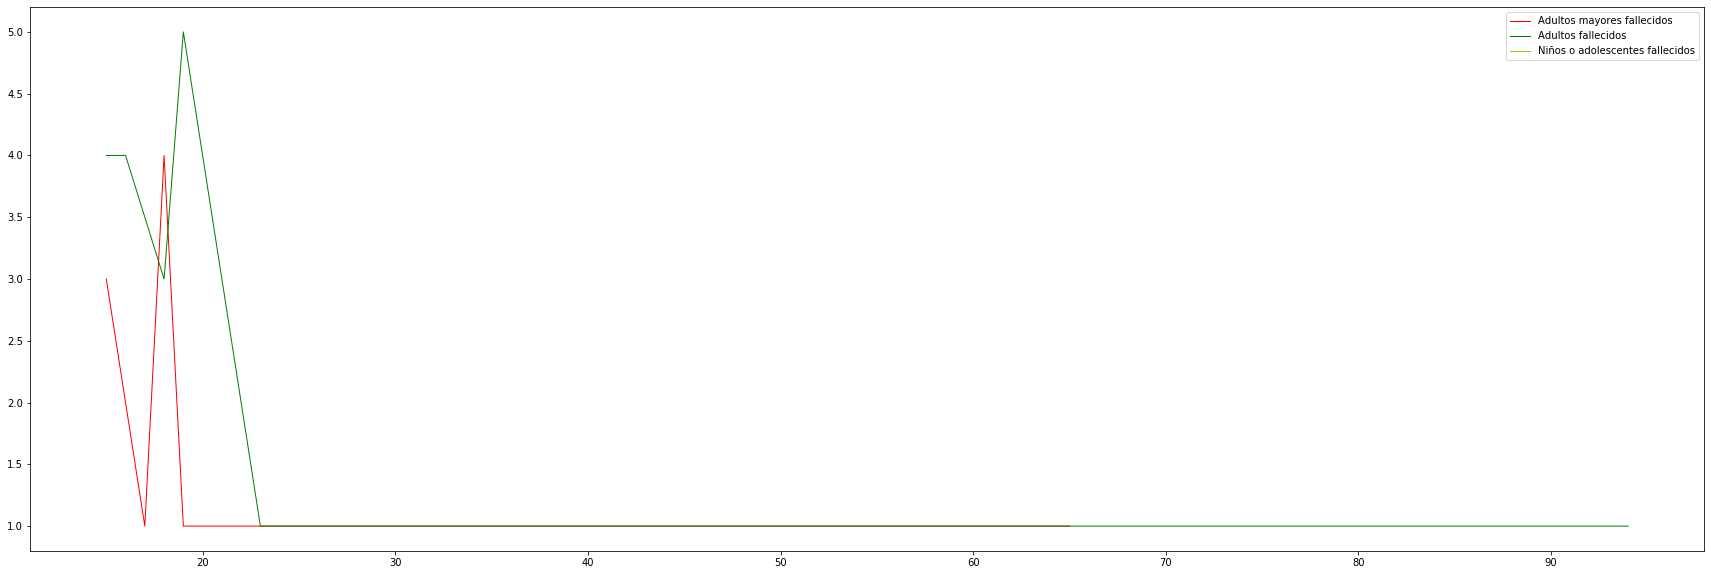

In [29]:
datos=sorted(cuidados_intensivos.items())
x, y =zip(*datos)

datos=sorted(adultoMs_fallecidos.items())
x1, y1 =zip(*datos)

datos=sorted(adultos_fallecidos.items())
x2, y2 =zip(*datos)

datos=sorted(ninios_fallecidos.items())
x3, y3 =zip(*datos)

fig = plt.figure(figsize=(30, 10))
ax = fig.add_subplot(111,  axisbelow=True)

ax.plot(x1, y1, 'r', alpha=1, lw=1, label='Adultos mayores fallecidos')
ax.plot(x2, y2, 'g', alpha=1, lw=1, label='Adultos fallecidos')
ax.plot(x3, y3, 'y', alpha=1, lw=1, label='Niños o adolescentes fallecidos')
legend = ax.legend()

print("PERSONAS FALLECIDAS")

CUIDADOS INTENSIVOS


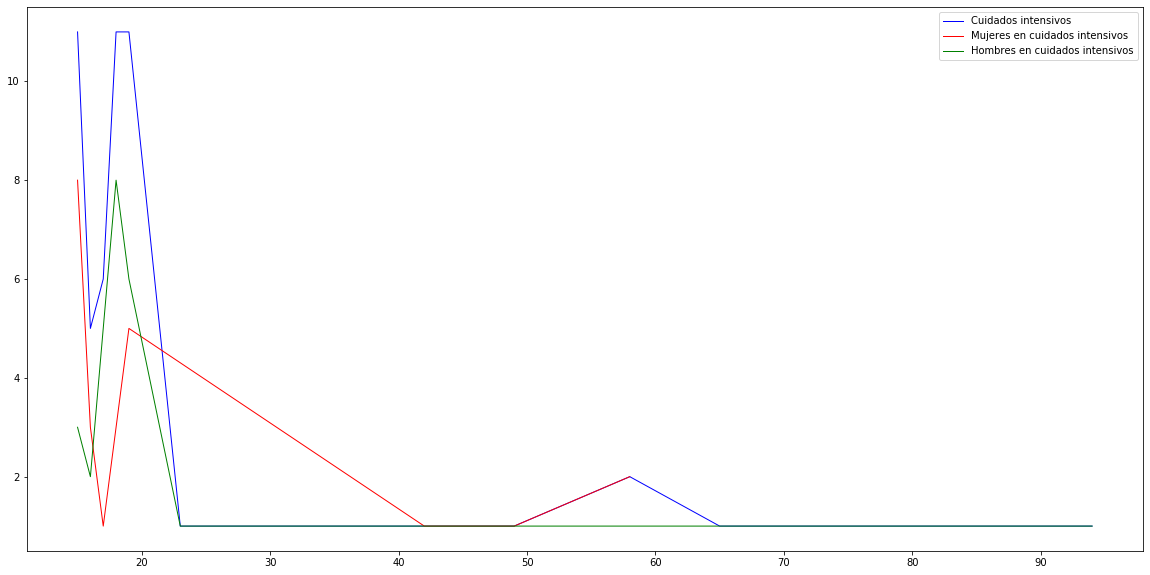

In [30]:
datos=sorted(cuidados_intensivos.items())
x, y =zip(*datos)

datos=sorted(mujeres_intensivos.items())
x1, y1 =zip(*datos)

datos=sorted(hombres_intensivos.items())
x2, y2 =zip(*datos)

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111,  axisbelow=True)
ax.plot(x, y, 'b', alpha=1, lw=1, label='Cuidados intensivos')
ax.plot(x1, y1, 'r', alpha=1, lw=1, label='Mujeres en cuidados intensivos')
ax.plot(x2, y2, 'g', alpha=1, lw=1, label='Hombres en cuidados intensivos')
legend = ax.legend()
print("CUIDADOS INTENSIVOS")

MUJERES Y HOMBRES QUE HAN FALLECIDO


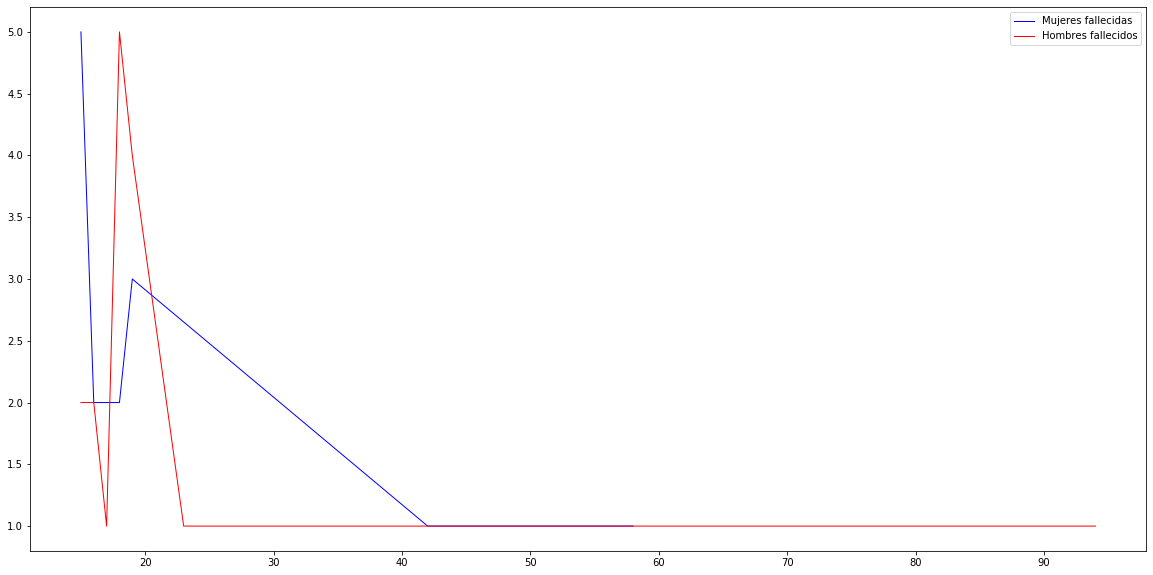

In [31]:
datos=sorted(mujeres_fallecidas.items())
x, y =zip(*datos)

datos=sorted(hombres_fallecidos.items())
x1, y1 =zip(*datos)

fig = plt.figure(figsize=(20, 10))

ax = fig.add_subplot(111,  axisbelow=True)
ax.plot(x, y, 'b', alpha=1, lw=1, label='Mujeres fallecidas')
ax.plot(x1, y1, 'r', alpha=1, lw=1, label='Hombres fallecidos')
legend = ax.legend()
print("MUJERES Y HOMBRES QUE HAN FALLECIDO")